# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Импорт библиотек

In [1]:
import os
import re
import nltk
import string
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from pymystem3 import Mystem
from catboost import CatBoostClassifier

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
nltk.download('stopwords')
stop_list = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Загрузка данных

In [3]:
way_0 = r"C:\Users\Кильдияров\Downloads\toxic_comments.csv"
way_1 = '/datasets/toxic_comments.csv'
if os.path.exists(way_0):
    df = pd.read_csv(way_0)
elif os.path.exists(way_1):
    df = pd.read_csv(way_1)
else:
    print('Error (o_O)')

Проверим, что все данные загрузились корректно

In [4]:
df.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


Данные загрузилиьсь корректно, теперь необходимо посмотреть количество пропусков и дубликатов

In [5]:
print(f'Количество пропусков: {df.isna().sum().sum()}')
print(f'Количество дубликатов: {df.duplicated().sum().sum()}')

Количество пропусков: 0
Количество дубликатов: 0


Данные в полном порядке, необходимо посмотреть баланс в целевом признаке

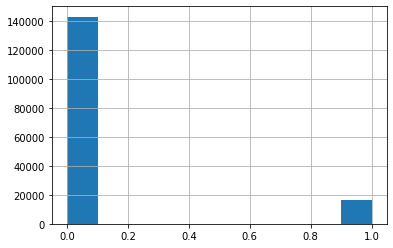

In [6]:
df.toxic.hist();

Существует явный дизбаланс в целевом признаке, так как колличество токсичных комментариев намного меньше, чем количество нетоксичных комментариев. При обучении моделей необходимо будет учесть этот факт 

In [7]:
# Разделим данные 
train, test = train_test_split(df, 
                              test_size = 0.25, 
                              random_state = 12345
                              )
features_train, target_train = train.drop(['toxic', 'Unnamed: 0'], axis = 1), train['toxic']
features_test, target_test = test.drop(['toxic', 'Unnamed: 0'], axis = 1), test['toxic']
# Посмотрим корректность поделенных данных
print(f'features_train: {features_train.shape}')
print(f'features_test: {features_test.shape}')
print(f'target_train: {target_train.shape}')
print(f'target_test: {target_test.shape}')

features_train: (119469, 1)
features_test: (39823, 1)
target_train: (119469,)
target_test: (39823,)


Данные поделены корректно, проведем предобработку текста

Напишем функцию, которая предложение разбивает на токены, убирает излишнюю пунктуацию, убирает стоп-слова и проводит стемминг (Лемматизацию)

In [8]:
snowball = SnowballStemmer(language = 'english')
english_stop_words = stopwords.words('english')
def tokanize(text):
    tokens = word_tokenize(text, language = 'english')
    tokens = [i for i in tokens if i not in string.punctuation]
    tokens = [i for i in tokens if i not in english_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return " ".join(tokens)

In [9]:
features_train['processed_text'] = features_train['text'].apply(tokanize)
features_test['processed_text'] = features_test['text'].apply(tokanize)
features_train.head()

,text,processed_text
116419,That makes no sense. You don't play MapleStory...,that make sens you n't play maplestori interne...
78749,"""\n\n Numbers killled \n\nThe existing text ma...",`` number killl the exist text match similar u...
73523,"Privyet! 20:49, Oct 12, 2004 (UTC)",privyet 20:49 oct 12 2004 utc
157127,Let him. Stop posting comments on my talk page...,let stop post comment talk page i 'm unblock yea
51825,"""\n Hello, , and Welcome to Wikipedia!\nPlease...",`` hello welcom wikipedia pleas rememb sign na...


In [10]:
count_tf_idf = TfidfVectorizer(stop_words = list(stop_list))
tf_idf_train = count_tf_idf.fit_transform(features_train['processed_text'])
tf_idf_test = count_tf_idf.transform(features_test['processed_text'])
print(tf_idf_train.shape)
print(tf_idf_test.shape)

(119469, 132883)
(39823, 132883)


## Обучение

Для подбора лучшей модели будем выбирать одну из трех моделей: LogisticRegression, RandomForestClassifier и модель градиентного бустинга: Catboost. Выбирать наиболее подходящую модель будем по 3 параметрам: 
1) значение метрики на тренировочных данных  
2) время предсказания  
3) время обучения модели

Описание нашей метрики для GridSearchCV

**Инициализация LogisticRegression**

In [17]:
model_lg = LogisticRegression(class_weight = 'balanced', 
                              random_state = 12345)
parametr = {'C' : [x for x in np.arange(0.1, 1, 0.1)]}
grid_model_lg = GridSearchCV(model_lg,
                             parametr,
                             cv = 3, 
                             scoring = 'f1'
                            )
grid_model_lg.fit(tf_idf_train, target_train)
print(f'Лучшие параметры: {grid_model_lg.best_params_}')
print(f'Значение метрики: {grid_model_lg.best_score_:.2f}')

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Лучшие параметры: {'C': 0.9}
Значение метрики: 0.74


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Замерим время обучения модели

In [18]:
%%time
grid_model_lg.best_estimator_.fit(tf_idf_train, target_train)

CPU times: user 15.3 s, sys: 28.7 s, total: 44 s
Wall time: 44 s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.9, class_weight='balanced', random_state=12345)

Замерим время предсказания модели

In [19]:
%%time
predictions = grid_model_lg.best_estimator_.predict(tf_idf_test)

CPU times: user 13.5 ms, sys: 37.6 ms, total: 51.1 ms
Wall time: 9.55 ms


**Инициализация RandomForestClassifier**

In [20]:
model_rfc = RandomForestClassifier(class_weight = 'balanced',
                                   random_state = 12345
                                  )
parameters = {'max_depth': [x for x in range(2, 12, 2)],
              'n_estimators': [x for x in range(50, 251, 50)]
             }
grid_model_rfc = GridSearchCV(model_rfc,
                             parameters,
                             cv = 3,
                             scoring = 'f1'
                             )
grid_model_rfc.fit(tf_idf_train, target_train)
print(f'Лучшие параметры: {grid_model_rfc.best_params_}')
print(f'Значение метрики: {grid_model_rfc.best_score_:.2f}')

Лучшие параметры: {'max_depth': 10, 'n_estimators': 150}
Значение метрики: 0.36


Замерим время обучения модели

In [21]:
%%time
grid_model_rfc.best_estimator_.fit(tf_idf_train, target_train)

CPU times: user 5.48 s, sys: 117 ms, total: 5.6 s
Wall time: 5.61 s


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=150,
                       random_state=12345)

Замерим время предсказания модели

In [22]:
%%time
predictions = grid_model_rfc.best_estimator_.predict(tf_idf_test)

CPU times: user 886 ms, sys: 22 ms, total: 908 ms
Wall time: 914 ms


Замерим время предсказания модели

Замерим время обучения модели

## Промежуточный вывод
1) Результаты LogisticRegression: 

    -Время обучения: 48.1 s
    -Время предсказания: 92.9 ms
    -RMSE на тренировочной выборке: 0.74
2) Результаты RandomForestClassifier:  

    -Время обучения:  4.95 s
    -Время предсказания: 872 ms
    -RMSE на тренировочной выборке: 0.36
**Итог: По полученным результатам наиболее подходящая модель: LogisticRegression. С гиперпараметрами: (C=0.9, class_weight='balanced', random_state=12345)**

Проверим значение метрики на тестовых данных

In [26]:
model = LogisticRegression(C = 0.9, class_weight = 'balanced', random_state = 12345)
model.fit(tf_idf_train, target_train)
predictions = model.predict(tf_idf_test)
print(f'Значение метрики на тестовых данных: {f1_score(target_test, predictions):.2f}')

Значение метрики на тестовых данных: 0.75


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Проверим модель на адекватность**

In [27]:
model_dr = DummyClassifier(strategy = "stratified")
model_dr.fit(tf_idf_train, target_train)
predictions_dr = model_dr.predict(tf_idf_test)
print(f'Значение f1_score для константной модели: {f1_score(target_test, predictions_dr):.2f}')

Значение f1_score для константной модели: 0.10


# Вывод:  
Нашей целью было найти и обучить модель для магазина "ВИКИШОП", которая способна классифицировать комментарии на позитивные и негативные для того, чтобы в дальнейшем токсичные отзывы отправлялись на модерацию. При этом достигуть результата предсказания наилучшей модели по мерке F1 не меньше 0.75


В нашем распоряжении был набор данных с разметкой о токсичности правок, но для правильной работы предсказательных алгоритмов моделей нам пришлось очистить комментарии от лишних символов и пр.мусора, а так же прибегнуть к балансировке выборок методами upsample и downsamle, т.к. сильный дисбаланс в классах мог негативно повлиять на качество предсказания моделей.

Для определения наилучшей модели мы остановили наш выбор на трёх моделях CatBoost,LogisticRegression и RandomForestClassifier. По итогам сравнеиня победила модель LogisticRegression, которая набрала значение метрики 0.75, а модель DummyClassifier показала значение метрики: 0.11
